1. Imports

In [8]:
# Standard library imports
import warnings

# Third-party imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm

# Local application/library specific imports
import DeepMIMOv3
from LWM_v1_1 import lwm_model
from scenario_props import *
from generate_data import patch_maker, tokenizer
from inference import lwm_inference

warnings.filterwarnings('ignore')

In [9]:
# --- Configuration Constants ---
DEFAULT_NUM_UE_ANTENNAS = 1
DEFAULT_SUBCARRIER_SPACING = 30e3  # Hz
DEFAULT_BS_ROTATION = np.array([0, 0, -135])  # (x, y, z) degrees
DEFAULT_NUM_PATHS = 20
DATASET_FOLDER = './scenarios'

def get_parameters(scenario: str, bs_idx: int = 1) -> dict:
    """Constructs the parameter dictionary for DeepMIMOv3 data generation.

    Args:
        scenario: The name of the scenario (e.g., 'city_6_miami_v1').
        bs_idx: The index of the active base station.

    Returns:
        A dictionary of parameters compatible with DeepMIMOv3.generate_data.
    """
    # Retrieves scenario-specific properties (e.g., antenna counts)
    scenario_configs = scenario_prop()
    
    # Start with default DeepMIMO parameters
    parameters = DeepMIMOv3.default_params()

    # --- Base Configuration ---
    parameters['dataset_folder'] = DATASET_FOLDER
    # Assumes scenario format is 'name_vX' and extracts the base name
    parameters['scenario'] = scenario.split("_v")[0]
    parameters['active_BS'] = np.array([bs_idx])
    parameters['enable_BS2BS'] = False
    parameters['num_paths'] = DEFAULT_NUM_PATHS

    # --- Scenario-Specific Configuration ---
    n_ant_bs = scenario_configs[scenario]['n_ant_bs']
    n_subcarriers = scenario_configs[scenario]['n_subcarriers']
    user_rows_config = scenario_configs[scenario]['n_rows']

    if isinstance(user_rows_config, int):
        parameters['user_rows'] = np.arange(user_rows_config)
    else: # Assumes a tuple or list [start, end]
        parameters['user_rows'] = np.arange(user_rows_config[0], user_rows_config[1])

    # --- Antenna and OFDM Configuration ---
    parameters['bs_antenna']['shape'] = np.array([n_ant_bs, 1])  # [Horizontal, Vertical]
    parameters['bs_antenna']['rotation'] = DEFAULT_BS_ROTATION
    parameters['ue_antenna']['shape'] = np.array([DEFAULT_NUM_UE_ANTENNAS, 1])
    parameters['OFDM']['subcarriers'] = n_subcarriers
    parameters['OFDM']['selected_subcarriers'] = np.arange(n_subcarriers)
    parameters['OFDM']['bandwidth'] = (DEFAULT_SUBCARRIER_SPACING * n_subcarriers) / 1e9  # GHz

    return parameters

def deepmimo_data_cleaning(deepmimo_data):
    """Cleans DeepMIMO data by removing users without a LoS path and scales channel coefficients.

    Args:
        deepmimo_data (dict): The raw data dictionary returned by DeepMIMOv3.generate_data.

    Returns:
        np.ndarray: Cleaned and scaled channel data for users with a valid path.
                    The channel coefficients are multiplied by CHANNEL_SCALING_FACTOR
                    for numerical stability in subsequent processing (e.g., ML models).
    """
    # Define a constant for the scaling factor
    CHANNEL_SCALING_FACTOR = 1e6

    # Identify users with a Line-of-Sight (LoS) path (LoS != -1 indicates a valid path)
    valid_user_indices = np.where(deepmimo_data['user']['LoS'] != -1)[0]

    # Select channel data only for valid users
    cleaned_channels = deepmimo_data['user']['channel'][valid_user_indices]

    # Scale the channel coefficients for numerical stability
    return cleaned_channels * CHANNEL_SCALING_FACTOR

def deepmimo_data_gen(scenario_names: list[str], bs_idxs: list[int] | None = None) -> list[dict]:
    """Generates DeepMIMO channel data for multiple scenarios and base stations.

    Args:
        scenario_names: A list of scenario name strings to generate data for.
        bs_idxs: A list of base station indices to use for each scenario.
                 Defaults to [1, 2, 3] if not provided.

    Returns:
        A list of dictionaries, where each dictionary contains the 'scenario'
        identifier and the corresponding 'channels' data (np.ndarray).
    """
    if bs_idxs is None:
        bs_idxs = [1, 2, 3]

    deepmimo_data = []
    
    # Create a list of all (scenario, bs) pairs to iterate over
    generation_tasks = [(name, idx) for name in scenario_names for idx in bs_idxs]

    # Use tqdm for a user-friendly progress bar
    print(f"Generating data for {len(generation_tasks)} scenario-BS pairs...")
    for scenario_name, bs_idx in tqdm(generation_tasks, desc="Data Generation"):
        parameters = get_parameters(scenario_name, bs_idx)
        # The [0] index selects the user data from the DeepMIMO output
        raw_deepmimo_data = DeepMIMOv3.generate_data(parameters)[0]
        cleaned_channels = deepmimo_data_cleaning(raw_deepmimo_data)
        deepmimo_data.append({"scenario": f"{scenario_name} - BS{bs_idx}", "channels": cleaned_channels})

    return deepmimo_data

def sample(deepmimo_data: list[dict], N_samples: int, n_users: int) -> list[dict]:
    """Generates samples by randomly selecting a scenario and a subset of users' channels.

    Each sample consists of channel data for 'n_users' randomly chosen users
    from a randomly selected scenario.

    Args:
        deepmimo_data: A list of dictionaries, where each dict contains
                       'scenario' (str) and 'channels' (np.ndarray) data.
        N_samples: The total number of samples to generate.
        n_users: The number of users (channels) to select for each sample.

    Returns:
        A list of dictionaries, each representing a sample with 'scenario' and
        'channels' (np.ndarray of shape (n_users, ...)).
    """
    samples = []

    for _ in tqdm(range(N_samples), desc="Sampling"):
        # Randomly select a scenario from the deepmimo_data list
        scenario_idx = np.random.randint(0, len(deepmimo_data))
        selected_scenario_data = deepmimo_data[scenario_idx]
        
        # Randomly select 'n_users' channel indices from the chosen scenario
        num_available_users = selected_scenario_data["channels"].shape[0] # Use shape[0] for number of users
        ue_idxs = np.random.choice(num_available_users, n_users, replace=False) # Use np.random.choice for unique indices
        
        selected_channels = selected_scenario_data["channels"][ue_idxs]

        samples.append({"scenario": selected_scenario_data["scenario"], "channels": selected_channels})

    return samples

def load_lwm_model(model_path: str, device: torch.device) -> nn.Module:
    """Loads the pre-trained LWM model and prepares it for inference"""
    print("Loading LWM model...")
    model = lwm_model.lwm().to(device)
    
    state_dict = torch.load(model_path, map_location=device)
    # Remove 'module.' prefix if the model was saved with DataParallel
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)

    # Use DataParallel if multiple GPUs are available 
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for inference.")
        model = nn.DataParallel(model)

    model.eval() # Set model to evaluation mode
    print("Model loaded successfully.")
    return model
    # --- Dataset Generatio ---

SCENARIO_NAMES = ["city_6_miami"]
BS_IDXS = [1, 2, 3]
N_SAMPLES = 5000
N_USERS = 4

deepmimo_data = deepmimo_data_gen(SCENARIO_NAMES, BS_IDXS)
dataset = sample(deepmimo_data, N_SAMPLES, N_USERS)

# --- Main Feature Extraction Logic ---
# 1. Define configuration and load the model ONCE
INFERENCE_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LWM_MODEL_PATH = "LWM_v1_1/models/model.pth"
lwm_model_instance = load_lwm_model(LWM_MODEL_PATH, INFERENCE_DEVICE)

# 2. Prepare all data for batch inference
all_tokens = []
for item in tqdm(dataset, desc="Preparing data"):
    # Prepare input tokens for the LWM model
    patches = patch_maker(item["channels"], 4, 4)
    tokens = tokenizer(patches)
    all_tokens.append(tokens)

    # Reshape channel data for the next stage (the regressor model)
    # Original shape: (K, 1, M, S) -> (4, 1, 16, 32)
    # Squeezed shape: (K, M, S) -> (4, 16, 32)
    # Transposed shape: (S, K, M) -> (32, 4, 16)
    item["channels"] = item["channels"].squeeze().transpose(2, 0, 1)

# 3. Run inference on the entire batch at once
print("Running batch inference...")
# Stack all tokens into a single tensor for efficient processing
# Shape changes from a list of [N_USERS, ...] tensors to one [N_SAMPLES * N_USERS, ...] tensor
all_tokens_tensor = torch.cat(all_tokens, dim=0)

# Perform inference ONCE for all samples
all_embeddings_tensor = lwm_inference(lwm_model_instance, all_tokens_tensor, "cls_emb", INFERENCE_DEVICE)

# 4. Assign the generated embeddings back to the dataset
print("Assigning embeddings...")
# Reshape embeddings to match the dataset structure: [N_SAMPLES, N_USERS, EMBED_DIM]
all_embeddings_tensor = all_embeddings_tensor.view(N_SAMPLES, N_USERS, -1)


# 1. Consolidate channels into a single tensor

# The channel data was already reshaped and stored as numpy arrays in the previous step.
all_channels_tensor = torch.from_numpy(np.array([d['channels'] for d in dataset])).cfloat()

# 2. Define split sizes and batch size
SPLIT = [int(0.7*N_SAMPLES), int(0.2*N_SAMPLES), int(0.1*N_SAMPLES)]
BATCH_SIZE= 32

# 3. Create the TensorDataset and split it
base_dataset = TensorDataset(all_channels_tensor, all_embeddings_tensor)
train_subset, val_subset, test_subset = random_split(base_dataset, SPLIT)

# 4. Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

Generating data for 3 scenario-BS pairs...


Data Generation:   0%|          | 0/3 [00:00<?, ?it/s]


Basestation 1

UE-BS Channels


Data Generation:  33%|███▎      | 1/3 [00:06<00:13,  6.54s/it]


Basestation 2

UE-BS Channels


Data Generation:  67%|██████▋   | 2/3 [00:12<00:06,  6.20s/it]


Basestation 3

UE-BS Channels


Sampling: 100%|██████████| 5000/5000 [00:01<00:00, 4626.82it/s]


Loading LWM model...
Model loaded successfully.


Preparing data: 100%|██████████| 5000/5000 [00:01<00:00, 2964.99it/s]


Running batch inference...
Assigning embeddings...


In [10]:
EPS = 1e-8
LN2 = torch.log(torch.tensor(2.0))

# -------------------------
# Example regressor model
# -------------------------
class RegressorBeamformer(nn.Module):
    """
    Input:
      embeddings: (B, K, emb_dim)
    Output:
      f_r, f_i: real and imag parts of precoder columns
        shapes: (B, S, K, M)
      p: powers (B, S, K)
    Parameterization: direction (unit-norm complex vector) + power scalars.
    """
    def __init__(self, emb_dim, K, M, S, hidden=256):
        super().__init__()
        self.K = K
        self.M = M
        self.S = S

        # Per-user encoder: shared MLP applied to each user's embedding.
        # We process (B, K, emb_dim) as a sequence of K tokens.
        self.user_encoder = nn.Sequential(
            nn.Linear(emb_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )

        # Cross-user interaction: a small transformer-like attention block (optional but helps)
        # We'll implement a single self-attention layer over K users.
        self.attn = nn.MultiheadAttention(embed_dim=hidden, num_heads=4, batch_first=True)
        self.attn_ln = nn.LayerNorm(hidden)

        # Heads produce per-subcarrier outputs for each user:
        # - direction head outputs 2*M*S values (real+imag flattened) per user embedding token
        # - power head outputs S scalars per user token
        self.dir_head = nn.Linear(hidden, S * M * 2)  # real+imag
        self.pow_head = nn.Linear(hidden, S)          # raw scalars per subcarrier

        # optionally: small residual MLP after attention
        self.post = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU())

    def forward(self, embeddings):
        # embeddings: (B, K, emb_dim)
        B, K, emb_dim = embeddings.shape
        assert K == self.K, f"K mismatch: {K} vs {self.K}"

        # encode per user
        z = self.user_encoder(embeddings.view(B * K, emb_dim))  # (B*K, hidden)
        z = z.view(B, K, -1)  # (B, K, hidden)

        # cross-user attention (query=key=value=z)
        attn_out, _ = self.attn(z, z, z, need_weights=False)  # (B,K,hidden)
        z = self.attn_ln(z + attn_out)
        z = self.post(z)  # (B,K,hidden)

        # produce heads
        dir_raw = self.dir_head(z)  # (B,K, S*M*2)
        pow_raw = self.pow_head(z)  # (B,K,S)

        # reshape directions: we want (B, S, K, M, 2)
        dir_raw = dir_raw.view(B, K, self.S, self.M, 2).permute(0, 2, 1, 3, 4)  # (B,S,K,M,2)
        pow_raw = pow_raw.permute(0, 2, 1)  # -> (B, S, K)  (from (B,K,S))

        # separate real/imag
        dir_r = dir_raw[..., 0]  # (B,S,K,M)
        dir_i = dir_raw[..., 1]  # (B,S,K,M)

        # normalize directions to unit-norm per (b,s,k)
        # Stack real and imaginary parts to treat as a vector for norm calculation
        u_complex = torch.complex(dir_r, dir_i)
        norm = torch.linalg.vector_norm(u_complex, dim=-1, keepdim=True) # (B,S,K,1)
        u = u_complex / (norm + EPS)

        # positive scalars via softplus
        alpha = F.softplus(pow_raw) + EPS  # (B,S,K)

        return (u.real, u.imag), alpha  # directions unit-norm; alpha positive but unscaled

# -------------------------
# Sum-rate computation
# -------------------------
def compute_sumrate_from_directions(u_r, u_i, alpha, H_r, H_i, P_total, noise_var):
    """
    Inputs:
      u_r, u_i: (B, S, K, M) unit-norm directions (real, imag)
      alpha: (B, S, K) positive raw scalars -> we'll scale to meet P_total
      H_r, H_i: (B, S, K, M) channel real/imag (user k's row vector)
      P_total: scalar or tensor shape (B,) total power per sample
      noise_var: scalar or tensor shape (B, S, K) or scalar
    Returns:
      sumrate: (B,) bits per channel use (sum over S and K)
      f_r, f_i: precoder columns real/imag shapes (B,S,K,M)
      p: powers (B,S,K)
    """
    B, S, K, M = u_r.shape
    # Scale alpha to meet total-power constraint per sample
    alpha_flat = alpha.reshape(B, -1)  # (B, S*K)
    alpha_sum = alpha_flat.sum(dim=-1, keepdim=True)  # (B,1)
    # allow P_total to be scalar or tensor
    if isinstance(P_total, (float, int)):
        P_total = torch.full((B, 1), float(P_total), device=alpha.device, dtype=alpha.dtype)
    else:
        P_total = P_total.view(B, 1)

    p_flat = P_total * (alpha_flat / (alpha_sum + EPS))  # (B, S*K)
    p = p_flat.view(B, S, K)  # (B,S,K)

    # Construct complex tensors for channel H, direction u, and precoder F
    H = torch.complex(H_r, H_i)  # (B,S,K,M)
    u = torch.complex(u_r, u_i)  # (B,S,K,M)
    sqrtp = torch.sqrt(p).unsqueeze(-1)  # (B,S,K,1)
    F = sqrtp * u  # (B,S,K,M)

    # Compute pairwise inner products G_kj = h_k^H * f_j for all k,j
    # H is (B,S,K,M), F is (B,S,K,M). We want G of shape (B,S,K,K)
    # G[b,s,k,j] = inner_product(H[b,s,k,:], F[b,s,j,:])
    G = torch.einsum('bskm,bsjm->bskj', H.conj(), F) # (B,S,K,K)
    power_matrix = G.abs()**2

    # desired signal power: diagonal j==k
    sig = torch.diagonal(power_matrix, dim1=-2, dim2=-1) # (B,S,K)
    tot = power_matrix.sum(dim=-1) # (B,S,K)
    interf = tot - sig

    # noise_var: allow scalar or tensor
    if isinstance(noise_var, (float, int)):
        noise = float(noise_var)
    else:
        noise = noise_var

    sinr = sig / (noise + interf + EPS)
    rate = torch.log1p(sinr) / LN2  # bits/channel use
    sumrate = rate.sum(dim=(1,2))   # sum over S and K -> (B,)
    return sumrate, F.real, F.imag, p

In [11]:
# --- Training Configuration ---
N_EPOCHS = 50
LEARNING_RATE = 1e-3
P_TOTAL = 1.0
NOISE_VARIANCE = 1e-3

# --- Model and Optimizer Initialization ---
# Extract dimensions from data
_, S, K, M = all_channels_tensor.shape
_, _, EMBED_DIM = all_embeddings_tensor.shape

# Instantiate the regressor model and move it to the correct device
regressor_model = RegressorBeamformer(emb_dim=EMBED_DIM, K=K, M=M, S=S).to(INFERENCE_DEVICE)

# Setup the optimizer
optimizer = torch.optim.Adam(regressor_model.parameters(), lr=LEARNING_RATE)

history = {"train_loss": [], "val_loss": []}
print("Starting training...")

for epoch in range(N_EPOCHS):
    # --- Training Step ---
    regressor_model.train()
    total_train_loss = 0.0

    for channels_batch, embeddings_batch in train_loader:
        # Move batch to device
        channels_batch = channels_batch.to(INFERENCE_DEVICE)
        embeddings_batch = embeddings_batch.to(INFERENCE_DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: get directions and power scalars from the model
        (u_r, u_i), alpha = regressor_model(embeddings_batch)

        # Calculate sum-rate 
        sumrate_batch, _, _, _ = compute_sumrate_from_directions(u_r, u_i, alpha,
                                                                 channels_batch.real, channels_batch.imag,
                                                                 P_TOTAL, NOISE_VARIANCE)
        
        # The loss is the negative of the sum-rate
        loss = -torch.mean(sumrate_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)

    # --- Validation Step ---
    regressor_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for channels_batch, embeddings_batch in val_loader:
            # Move batch to device
            channels_batch = channels_batch.to(INFERENCE_DEVICE)
            embeddings_batch = embeddings_batch.to(INFERENCE_DEVICE)

            (u_r, u_i), alpha = regressor_model(embeddings_batch)

            sumrate_batch, _, _, _ = compute_sumrate_from_directions(u_r, u_i, alpha,
                                                                 channels_batch.real, channels_batch.imag,
                                                                 P_TOTAL, NOISE_VARIANCE)

            loss = -torch.mean(sumrate_batch)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    history["val_loss"].append(avg_val_loss)

    print(f"Epoch {epoch+1}/{N_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Starting training...
Epoch 1/50 | Train Loss: -135.6034 | Val Loss: -220.5552
Epoch 2/50 | Train Loss: -230.0141 | Val Loss: -221.6356
Epoch 3/50 | Train Loss: -240.6213 | Val Loss: -238.6027
Epoch 4/50 | Train Loss: -243.3436 | Val Loss: -246.3712
Epoch 5/50 | Train Loss: -245.1835 | Val Loss: -251.4467
Epoch 6/50 | Train Loss: -249.8523 | Val Loss: -248.6934
Epoch 7/50 | Train Loss: -247.6766 | Val Loss: -232.2406
Epoch 8/50 | Train Loss: -250.8183 | Val Loss: -254.1629
Epoch 9/50 | Train Loss: -252.5997 | Val Loss: -255.3101
Epoch 10/50 | Train Loss: -250.9345 | Val Loss: -250.1584
Epoch 11/50 | Train Loss: -250.9376 | Val Loss: -252.6808
Epoch 12/50 | Train Loss: -252.1302 | Val Loss: -240.6361
Epoch 13/50 | Train Loss: -254.4962 | Val Loss: -254.7657
Epoch 14/50 | Train Loss: -255.7280 | Val Loss: -254.1083
Epoch 15/50 | Train Loss: -255.5504 | Val Loss: -239.4819
Epoch 16/50 | Train Loss: -254.6739 | Val Loss: -254.6068
Epoch 17/50 | Train Loss: -259.0118 | Val Loss: -255.8773
Ep

In [12]:
# Você pode adicionar este código em uma nova célula do seu notebook
# para realizar a comparação após o treinamento.

# Importe as funções necessárias do seu módulo.
# Assumindo que o notebook está no diretório 'src' ou que o path está configurado.
from power_allocation import mmse_precoder, beamforming, power_allocation_wmmse_fixed_dirs

def wmmse_benchmark(H_batch, P_tot, noise_var, max_iter=10):
    """
    Calcula a sum-rate usando o algoritmo WMMSE iterativo para um batch de canais.

    Args:
        H_batch (np.ndarray): Batch de canais com shape (B, S, K, M).
        P_tot (float): Potência total.
        noise_var (float): Variância do ruído.
        max_iter (int): Número de iterações do WMMSE.

    Returns:
        np.ndarray: Array com a sum-rate para cada amostra no batch, shape (B,).
    """
    B, S, K, M = H_batch.shape
    batch_sum_rates = np.zeros(B)

    # Itera sobre cada amostra no batch
    for b in range(B):
        total_sum_rate_per_sample = 0.0
        
        # Itera sobre cada subportadora (subcarrier)
        for s in range(S):
            H = H_batch[b, s, :, :].T # Shape para (M, K)
            
            # 1. Inicialização: Começar com um pré-codificador MMSE simples
            W = mmse_precoder(H, P_tot, noise_var)

            # Loop iterativo do WMMSE
            for _ in range(max_iter):
                # 2. Extrai direções (F) e potências (p) do precodificador W
                F = beamforming(W)
                
                # 3. Otimiza a alocação de potência para as direções F atuais
                #    Esta é a função que você já possui!
                p_opt, _, _ = power_allocation_wmmse_fixed_dirs(H, F, P_tot, noise_var)
                
                # 4. Atualiza o precodificador W com as novas potências
                #    W_new = F * sqrt(p_opt)
                W = F * np.sqrt(p_opt[np.newaxis, :])

            # Calcula a sum-rate final para esta subportadora com o W otimizado
            # (Reutilizando a lógica de cálculo de SINR)
            p_final = np.sum(np.abs(W)**2, axis=0)
            G = H.conj().T @ W
            
            abs_G2 = np.abs(G)**2
            signal_power = np.diag(abs_G2)
            total_received_power = np.sum(abs_G2, axis=1)
            interference_power = total_received_power - signal_power
            
            sinr = signal_power / (interference_power + noise_var)
            rates = np.log2(1 + sinr)
            total_sum_rate_per_sample += np.sum(rates)

        batch_sum_rates[b] = total_sum_rate_per_sample
        
    return batch_sum_rates



In [13]:
# --- Célula de Comparação (adicionar após o treinamento) ---

print("Starting comparison with WMMSE benchmark...")

# Garanta que o modelo está em modo de avaliação
regressor_model.eval()

# Listas para armazenar os resultados
model_sum_rates = []
wmmse_sum_rates = []

# Use o test_loader que já foi criado
with torch.no_grad():
    for channels_batch, embeddings_batch in tqdm(test_loader, desc="Testing"):
        # --- 1. Obter resultado do seu modelo ---
        channels_batch_gpu = channels_batch.to(INFERENCE_DEVICE)
        embeddings_batch_gpu = embeddings_batch.to(INFERENCE_DEVICE)

        (u_r, u_i), alpha = regressor_model(embeddings_batch_gpu)

        sumrate_batch, _, _, _ = compute_sumrate_from_directions(
            u_r, u_i, alpha,
            channels_batch_gpu.real, channels_batch_gpu.imag,
            P_TOTAL, NOISE_VARIANCE
        )
        
        # Mover para CPU e guardar
        model_sum_rates.extend(sumrate_batch.cpu().numpy())

        # --- 2. Obter resultado do benchmark WMMSE ---
        # O WMMSE espera numpy arrays na CPU
        channels_batch_cpu = channels_batch.cpu().numpy()
        
        wmmse_rates_batch = wmmse_benchmark(
            channels_batch_cpu, 
            P_TOTAL, 
            NOISE_VARIANCE, 
            max_iter=20 # 10-20 iterações são geralmente suficientes
        )
        wmmse_sum_rates.extend(wmmse_rates_batch)

# --- 3. Analisar os resultados ---
model_sum_rates = np.array(model_sum_rates)
wmmse_sum_rates = np.array(wmmse_sum_rates)

avg_model_rate = np.mean(model_sum_rates)
avg_wmmse_rate = np.mean(wmmse_sum_rates)

print(f"\\nAverage Sum-Rate (Your Model): {avg_model_rate:.4f} bits/s/Hz")
print(f"Average Sum-Rate (WMMSE):      {avg_wmmse_rate:.4f} bits/s/Hz")
print(f"Performance Ratio (Model/WMMSE): {avg_model_rate / avg_wmmse_rate:.4f}")

# --- 4. (Opcional, mas recomendado) Plotar a CDF ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Função para plotar CDF
def plot_cdf(data, label):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    plt.plot(sorted_data, yvals, label=label)

plot_cdf(model_sum_rates, 'Regressor Model')
plot_cdf(wmmse_sum_rates, 'WMMSE Benchmark')

plt.title('CDF of Sum-Rate Performance')
plt.xlabel('Sum-Rate (bits/s/Hz)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.legend()
plt.show()



Starting comparison with WMMSE benchmark...


Testing:   0%|          | 0/16 [00:15<?, ?it/s]


KeyboardInterrupt: 

Starting comparison with WMMSE benchmark...


Testing:   0%|          | 0/16 [00:00<?, ?it/s]

Testing: 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


\nAverage Sum-Rate (Your Model): 271.5390 bits/s/Hz
Average Sum-Rate (WMMSE):      709.3940 bits/s/Hz
Average Sum-Rate (Model Dirs + Opt Power): 0.0000 bits/s/Hz
Average Sum-Rate (Opt Dirs + Model Power): 201.1588 bits/s/Hz

Performance Ratio (Model/WMMSE): 0.3828
Beamforming Performance (Hybrid1/WMMSE): 0.0000
Power Allocation Performance (Hybrid2/WMMSE): 0.2836
Performance Ratio (Model/WMMSE): 0.3828


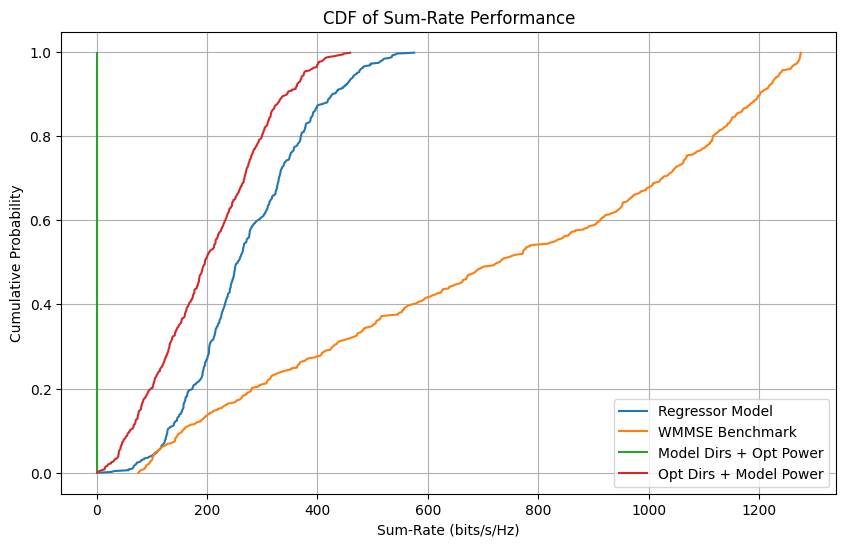

In [14]:
# --- Célula de Comparação (adicionar após o treinamento) ---
def wmmse_benchmark_torch(H_batch, P_total, noise_var, max_iter=20, eps=1e-12):
    """PyTorch implementation of the WMMSE algorithm for sum-rate maximization.
    PyTorch implementation of the WMMSE algorithm for sum-rate maximization.
    Processes a batch of channels entirely on the GPU.

    Args:
        H_batch (torch.Tensor): Complex channel tensor (B, S, K, M).
        P_total (float): Total power constraint per sample.
        noise_var (float): Noise variance.
        max_iter (int): Number of WMMSE iterations.
        eps (float): Small epsilon for numerical stability.

    Returns:
        torch.Tensor: Sum-rate for each sample in the batch, shape (B,).
        torch.Tensor: Final complex precoding matrix V, shape (B*S, M, K).
    """
    B, S, K, M = H_batch.shape
    device = H_batch.device

    # Reshape for batch processing: treat (B*S) as the batch dimension
    H = H_batch.view(B * S, K, M)
    H_t = H.transpose(-2, -1).conj() # (B*S, M, K)

    # 1. Initialization (e.g., with maximum ratio transmission)
    V = H_t / (torch.norm(H_t, dim=-2, keepdim=True) + eps) # (B*S, M, K)
    p = torch.full((B * S, K), P_total / (S * K), device=device, dtype=H.real.dtype)

    for _ in range(max_iter):
        # 2. Update MMSE Receivers (U)
        V_p = V * torch.sqrt(p.unsqueeze(-2)) # (B*S, M, K)
        G = H @ V_p # (B*S, K, K)
        
        inv_term = torch.linalg.inv(G @ G.conj().transpose(-2, -1) + noise_var * torch.eye(K, device=device))
        U = G.conj().transpose(-2, -1) @ inv_term # (B*S, K, K)
        U_diag = torch.diagonal(U, dim1=-2, dim2=-1) # (B*S, K)

        # 3. Update MMSE Weights (W_mse)
        W_mse = torch.ones((B*S, K), device=device) - torch.abs(U_diag)**2
        W_mse = 1.0 / (W_mse + eps)

        # 4. Update Precoder (V)
        B_matrix = W_mse.unsqueeze(-1) * U_diag.unsqueeze(-1) * U
        C_matrix = H_t @ B_matrix @ H # (B*S, M, M)
        
        # Solve for water level lambda via bisection
        # This is a simplified but effective approach for the dual problem
        lam = torch.ones(B * S, 1, 1, device=device) * 0.001
        eye_M = torch.eye(M, device=device)
        for _ in range(10): # Bisection iterations
            inv_lam = torch.linalg.inv(C_matrix + lam * eye_M)
            V_lam = inv_lam @ H_t @ B_matrix
            p_lam = torch.sum(torch.abs(V_lam)**2, dim=-2)
            p_total_per_subcarrier = P_total / S
            # Update lambda based on power constraint
            mask = (torch.sum(p_lam, dim=-1) > p_total_per_subcarrier).unsqueeze(-1).unsqueeze(-1)
        lam = torch.where(mask, lam * 1.5, lam / 1.5)

        # Final precoder for this iteration
        V = torch.linalg.inv(C_matrix + lam * eye_M) @ H_t @ B_matrix
        p = torch.sum(torch.abs(V)**2, dim=-2)

    # --- Final Sum-Rate Calculation ---
    G_final = H @ V # (B*S, K, K)
    abs_G2 = torch.abs(G_final)**2
    sig = torch.diagonal(abs_G2, dim1=-2, dim2=-1) # (B*S, K)
    interf = torch.sum(abs_G2, dim=-1) - sig
    sinr = sig / (interf + noise_var + eps)
    rate = torch.log1p(sinr) / LN2
    
    # Reshape back to (B, S, K) and sum over S and K
    sumrate = rate.view(B, S, K).sum(dim=(-1, -2))
    return sumrate, V # Return final precoder as well

def power_allocation_wmmse_fixed_dirs_torch(H, F, P_total, noise_var, original_S, max_iter=50, tol=1e-6, eps=1e-12):
    """PyTorch implementation of WMMSE for fixed directions to optimize power.

    Args:
        H (torch.Tensor): Complex channel tensor (B*S, K, M).
        F (torch.Tensor): Fixed complex unit-norm directions (B*S, M, K).
        P_total (float): Total power constraint *per sample* (B).
        noise_var (float): Noise variance.
        original_S (int): Original number of subcarriers (S) from the batch.
    
    Returns:
        torch.Tensor: Optimized power vector p (B*S, K).
    """
    BS, K, M = H.shape # BS here is B * original_S
    device = H.device
    P_per_subcarrier = P_total / original_S # Total power for one subcarrier problem

    # Pre-calculate scalar gains g_kj = h_k^H f_j -> matrix KxK
    G = torch.einsum('bkm,bmj->bkj', H.conj(), F) # (BS, K, K)
    absG2 = torch.abs(G)**2

    p = torch.full((BS, K), P_per_subcarrier / K, device=device, dtype=H.real.dtype)

    for _ in range(max_iter):
        p_old = p
        # 1. Compute interference+noise for each user
        int_plus_noise = (absG2 @ p.unsqueeze(-1)).squeeze(-1) + noise_var # (BS, K)

        # 2. Compute u_k (scalar MMSE receiver)
        u = (torch.sqrt(p) * torch.diagonal(G, dim1=-2, dim2=-1).conj()) / int_plus_noise

        # 3. Compute MSE_k and weights w_k
        MSE = 1.0 - 2.0 * torch.real(u.conj() * torch.sqrt(p) * torch.diagonal(G, dim1=-2, dim2=-1)) + torch.abs(u)**2 * int_plus_noise
        w = 1.0 / torch.clamp(MSE, min=eps)

        # 5. Compute c_j and d_j for water-filling
        c = (w * torch.abs(u)**2).unsqueeze(1) @ absG2 # (BS, 1, K)
        d = w * torch.real(u.conj() * torch.diagonal(G, dim1=-2, dim2=-1))
        d = torch.clamp(d, min=0.0)

        # 6. Water-filling to find new power p
        # Simplified: 1/lambda = (sum_j d_j) / (P_tot * c_j + sum_j c_j*d_j)
        # Using bisection is more robust but this is a common approximation.
        # For simplicity, we use a single water-level for all samples in the batch.
        b = d / (c.squeeze(1) + eps) # (BS, K)
        sorted_b, _ = torch.sort(b, dim=-1, descending=True) # (BS, K)
        
        # Calculate candidates for lambda for each possible number of active users (1 to K)
        # For each BS entry, we have K candidates for lambda.
        # lambda_k = (sum_{j=1 to k} 1/b_j + P_total_subcarrier) / k
        inv_sorted_b = 1.0 / (sorted_b + eps) # (BS, K)
        cumsum_inv_sorted_b = torch.cumsum(inv_sorted_b, dim=-1) # (BS, K)
        k_indices = torch.arange(1, K + 1, device=device, dtype=H.real.dtype) # (K,)
        
        # Candidates for lambda for each BS entry, for each k_active from 1 to K
        lambda_candidates = (cumsum_inv_sorted_b + P_per_subcarrier) / k_indices # (BS, K)
        
        # Find the actual k_active for each BS entry
        # k_active is the largest k such that b_k * lambda_k > 1
        condition = (sorted_b * lambda_candidates) <= 1.0 # (BS, K)
        k_active = torch.sum(~condition, dim=-1) # (BS,) - number of elements where b_sorted * lambda_candidates > 1
        k_active = torch.clamp(k_active, min=1) # Ensure at least one user is active
        
        # Select the correct lambda for each BS entry
        # k_active is 1-indexed, so we need k_active - 1 for 0-indexed tensor access
        lam = torch.gather(lambda_candidates, dim=-1, index=(k_active - 1).unsqueeze(-1)).squeeze(-1) # (BS,)
        
        # Calculate new power p
        p = torch.clamp(1/lam.unsqueeze(-1) - 1/b, min=0.0) # (BS, K)
        
        # Renormalize power to P_per_subcarrier
        p = P_per_subcarrier * p / (torch.sum(p, dim=-1, keepdim=True) + eps) # (BS, K)

        if torch.norm(p - p_old) / (torch.norm(p_old) + eps) < tol:
            break

    return p

print("Starting comparison with WMMSE benchmark...")

# Garanta que o modelo está em modo de avaliação
regressor_model.eval()

# Listas para armazenar os resultados para todas as 4 categorias
model_sum_rates = []
wmmse_sum_rates = []
hybrid_model_dir_rates = []
hybrid_model_pow_rates = []

# Use o test_loader que já foi criado
with torch.no_grad():
    for channels_batch, embeddings_batch in tqdm(test_loader, desc="Testing"):
        # --- 1. Obter resultado do seu modelo ---
        channels_batch_gpu = channels_batch.to(INFERENCE_DEVICE)
        embeddings_batch_gpu = embeddings_batch.to(INFERENCE_DEVICE)

        # --- 1. Resultado do seu modelo (Direções + Potência) ---
        (u_r, u_i), alpha = regressor_model(embeddings_batch_gpu)
        model_sumrate_batch, _, _, _ = compute_sumrate_from_directions(
            u_r, u_i, alpha,
            channels_batch_gpu.real, channels_batch_gpu.imag,
            P_TOTAL, NOISE_VARIANCE
        )
        model_sum_rates.extend(model_sumrate_batch.cpu().numpy())

        # --- 2. Resultado do benchmark WMMSE (Direções Ótimas + Potência Ótima) ---
        wmmse_rates_batch, V_wmmse = wmmse_benchmark_torch(
            channels_batch_gpu, 
            P_TOTAL, 
            NOISE_VARIANCE
        )
        wmmse_sum_rates.extend(wmmse_rates_batch.cpu().numpy())

        # --- 3. Híbrido 1: Direções do Modelo + Potência Ótima ---
        # Obter direções do modelo
        B, S, K, M = channels_batch_gpu.shape
        u_model = torch.complex(u_r, u_i).permute(0, 2, 3, 1).reshape(B * K, M, S) # Requer ajuste de shape
        # A forma de F para a função de otimização de potência precisa ser (B*S, M, K)
        # u_model está como (B, S, K, M). Permutar para (B, S, M, K) e depois view
        F_model = torch.complex(u_r, u_i).permute(0, 1, 3, 2).reshape(B*S, M, K)
        H_reshaped = channels_batch_gpu.view(B*S, K, M)
        
        p_opt_for_model_dirs = power_allocation_wmmse_fixed_dirs_torch(H_reshaped, F_model, P_TOTAL, NOISE_VARIANCE, S)
        p_opt_for_model_dirs = p_opt_for_model_dirs.view(B, S, K)
        
        # Recalcular sum-rate com as direções do modelo e potência otimizada
        alpha_from_p_opt = p_opt_for_model_dirs / (torch.sum(p_opt_for_model_dirs, dim=(-1,-2), keepdim=True) + EPS) * P_TOTAL
        hybrid1_sumrate_batch, _, _, _ = compute_sumrate_from_directions(
            u_r, u_i, alpha_from_p_opt, # Usando alpha derivado da potência ótima
            channels_batch_gpu.real, channels_batch_gpu.imag,
            P_TOTAL, NOISE_VARIANCE
        )
        hybrid_model_dir_rates.extend(hybrid1_sumrate_batch.cpu().numpy())

        # --- 4. Híbrido 2: Direções Ótimas (WMMSE) + Potência do Modelo ---
        # Extrair direções do V_wmmse
        V_wmmse = V_wmmse.view(B, S, M, K)
        norm_V = torch.norm(V_wmmse, dim=-2, keepdim=True) + EPS
        F_wmmse = V_wmmse / norm_V # Direções (B, S, M, K)
        
        # Usar alpha do modelo para calcular a potência
        # A função `compute_sumrate_from_directions` espera direções (u) com shape (B, S, K, M).
        # F_wmmse está como (B, S, M, K), então precisamos permutar as duas últimas dimensões.
        F_wmmse_permuted = F_wmmse.permute(0, 1, 3, 2) # (B, S, K, M)
        hybrid2_sumrate_batch, _, _, _ = compute_sumrate_from_directions(
            F_wmmse_permuted.real, F_wmmse_permuted.imag, # Usando direções ótimas com o shape correto
            alpha, # Usando alpha (potência) do modelo
            channels_batch_gpu.real, channels_batch_gpu.imag,
            P_TOTAL, NOISE_VARIANCE
        )
        hybrid_model_pow_rates.extend(hybrid2_sumrate_batch.cpu().numpy())

# --- 3. Analisar os resultados ---
model_sum_rates = np.array(model_sum_rates)
wmmse_sum_rates = np.array(wmmse_sum_rates)
hybrid_model_dir_rates = np.array(hybrid_model_dir_rates)
hybrid_model_pow_rates = np.array(hybrid_model_pow_rates)

avg_model_rate = np.mean(model_sum_rates)
avg_wmmse_rate = np.mean(wmmse_sum_rates)
avg_hybrid1_rate = np.mean(hybrid_model_dir_rates)
avg_hybrid2_rate = np.mean(hybrid_model_pow_rates)

print(f"\\nAverage Sum-Rate (Your Model): {avg_model_rate:.4f} bits/s/Hz")
print(f"Average Sum-Rate (WMMSE):      {avg_wmmse_rate:.4f} bits/s/Hz")
print(f"Average Sum-Rate (Model Dirs + Opt Power): {avg_hybrid1_rate:.4f} bits/s/Hz")
print(f"Average Sum-Rate (Opt Dirs + Model Power): {avg_hybrid2_rate:.4f} bits/s/Hz")

print(f"\nPerformance Ratio (Model/WMMSE): {avg_model_rate / avg_wmmse_rate:.4f}")
print(f"Beamforming Performance (Hybrid1/WMMSE): {avg_hybrid1_rate / avg_wmmse_rate:.4f}")
print(f"Power Allocation Performance (Hybrid2/WMMSE): {avg_hybrid2_rate / avg_wmmse_rate:.4f}")
print(f"Performance Ratio (Model/WMMSE): {avg_model_rate / avg_wmmse_rate:.4f}")

# --- 4. (Opcional, mas recomendado) Plotar a CDF ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Função para plotar CDF
def plot_cdf(data, label):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    plt.plot(sorted_data, yvals, label=label)

plot_cdf(model_sum_rates, 'Regressor Model')
plot_cdf(wmmse_sum_rates, 'WMMSE Benchmark')
plot_cdf(hybrid_model_dir_rates, 'Model Dirs + Opt Power')
plot_cdf(hybrid_model_pow_rates, 'Opt Dirs + Model Power')

plt.title('CDF of Sum-Rate Performance')
plt.xlabel('Sum-Rate (bits/s/Hz)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.legend()
plt.show()

